In [1]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


# Setup

In [2]:
# install tensorflow 2.15 since voxelmorph is not compatible with current build
import tensorflow as tf
if not tf.__version__.startswith('2.15'):
  !pip uninstall -y tensorflow
  !pip install tensorflow==2.15
# install voxelmorph
!pip install voxelmorph

2024-08-13 15:39:16.111759: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import voxelmorph as vxm
import neurite as ne

import os
import urllib.request
import zipfile
import json
import nibabel as nib
import matplotlib.pyplot as plt
from matplotlib import colors, patches
import numpy as np

# Download dataset

In [4]:
# download dataset
filename = 'AbdomenCTCT.zip'
if not os.path.exists(filename):
    url = 'https://cloud.imi.uni-luebeck.de/s/32WaSRaTnFk2JeT/download/AbdomenCTCT.zip'
    urllib.request.urlretrieve(url, filename)

    # extract files
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall('./')

In [5]:
def load_data(jsonData, dataFolderPath, training_or_test, filterString='0001'):
    images = []
    labels = []
    for sample in jsonData[training_or_test]:
        image = nib.load(dataFolderPath + sample['image'].removeprefix('.').replace(".csv",".nii.gz")).get_fdata()
        images.append(image)
        if training_or_test == 'training':
          label = nib.load(dataFolderPath + sample['label'].removeprefix('.').replace(".csv",".nii.gz")).get_fdata()
          labels.append(label)

    return np.array(images), np.array(labels)

In [6]:
# load data
with open('./AbdomenCTCT/AbdomenCTCT_dataset.json', 'r') as file:
  data_json = json.load(file)
dataFolder = './AbdomenCTCT'
training_images_raw, training_labels_raw = load_data(data_json, dataFolder, 'training')

In [7]:
training_images_raw.shape

(30, 192, 160, 256)

In [8]:
training_labels_raw.shape

(30, 192, 160, 256)

# Preprocess data

In [9]:
# normalize images
training_images_normalized = (training_images_raw - np.min(training_images_raw)) / (np.max(training_images_raw) - np.min(training_images_raw))

# rotate tensor
training_images_rotated = np.array([np.rot90(image, k=1, axes=(0, 2)) for image in training_images_normalized])
training_labels_rotated = np.array([np.rot90(image, k=1, axes=(0, 2)) for image in training_labels_raw])

# swap and flip axes
training_images = np.swapaxes(training_images_rotated, 1, 2)[:, ::-1, :, :]
training_labels = np.swapaxes(training_labels_rotated, 1, 2)[:, ::-1, :, :]

# prepare tensor just with organs
training_organs = np.zeros_like(training_images)
training_organs[training_labels > 0] = training_images[training_labels > 0]

del training_images_raw
del training_labels_raw
del training_images_normalized
del training_images_rotated
del training_labels_rotated

(-0.5, 191.5, 255.5, -0.5)

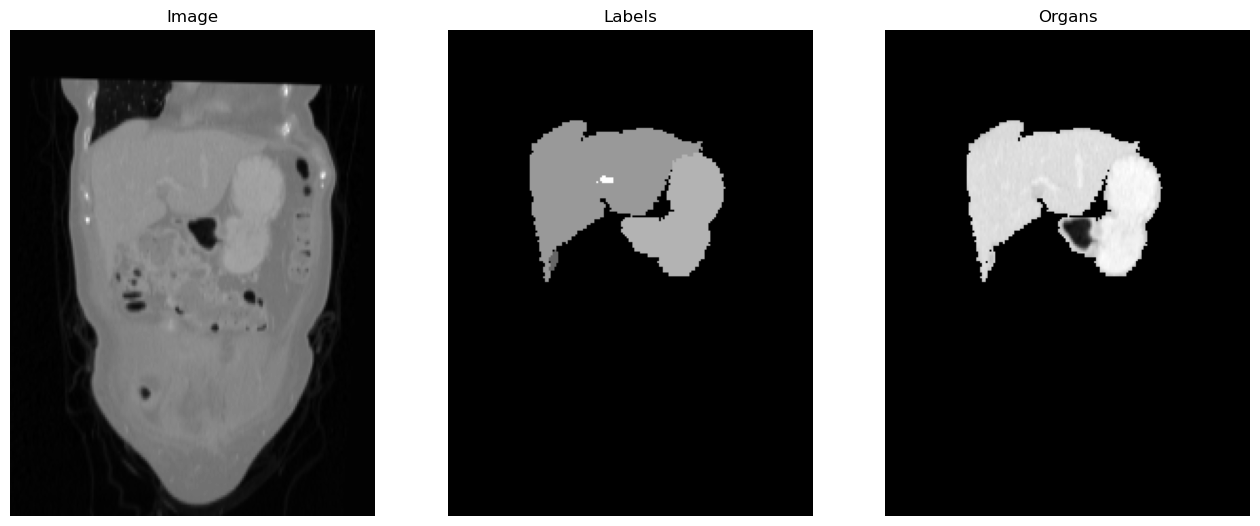

In [10]:
# preview data
img = 0
depth = 40

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(16,8))
ax0.imshow(training_images[img,depth],cmap='gray')
ax0.set_title("Image")
ax0.axis("off")
ax1.imshow(training_labels[img,depth], cmap='gray')
ax1.set_title("Labels")
ax1.axis("off")
ax2.imshow(training_organs[img,depth], cmap='gray')
ax2.set_title("Organs")
ax2.axis("off")

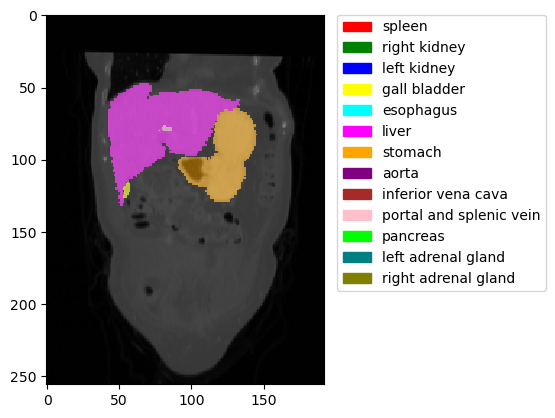

In [11]:
# setup colormap
cmap = colors.ListedColormap([
    'black', 'red', 'green', 'blue', 'yellow', 'cyan', 'magenta', 'orange',
    'purple', 'brown', 'pink', 'lime', 'teal', 'olive'
])
norm = colors.BoundaryNorm(boundaries=np.arange(-0.5, 14, 1), ncolors=14)

# view image
plt.imshow(training_images[img,depth], cmap='gray', interpolation='none')

# view colors
plt.imshow(training_labels[img,depth], cmap=cmap, norm=norm, alpha=0.5, interpolation='none')

# setup legend
legend_labels = {
    1: "spleen",
    2: "right kidney",
    3: "left kidney",
    4: "gall bladder",
    5: "esophagus",
    6: "liver",
    7: "stomach",
    8: "aorta",
    9: "inferior vena cava",
    10: "portal and splenic vein",
    11: "pancreas",
    12: "left adrenal gland",
    13: "right adrenal gland"
}

# view rectangles in legend
patches_list = [
    patches.Patch(color=cmap(i), label=legend_labels[i])
    for i in range(1, 14)
]

# view legend
plt.legend(handles=patches_list, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

# Define Model

In [12]:
# define the input shapes
inshape = training_organs.shape[1:]
nb_features = (
    (16, 32, 32), # encoder-channels
    (32, 32, 16) # eecoder-channels
    )
# build model using VxmDense
vxm_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)

# Load weights

In [13]:
vxm_model.load_weights('AbdomenCTCT_full_model.h5')
                       
print('input shape: ', ', '.join([str(t.shape) for t in vxm_model.inputs]))
print('output shape:', ', '.join([str(t.shape) for t in vxm_model.outputs]))

input shape:  (None, 160, 256, 192, 1), (None, 160, 256, 192, 1)
output shape: (None, 160, 256, 192, 1), (None, 160, 256, 192, 3)


# Test registration

In [14]:
# define a data generator
def test_data_generator(data):
    vol_shape = data.shape[1:]
    ndims = len(vol_shape)

    while True:
        idx1 = np.random.randint(0, data.shape[0], size=1)
        idx2 = np.random.randint(0, data.shape[0], size=1)

        fixed_image = data[idx1, ..., np.newaxis]
        moving_image = data[idx2, ..., np.newaxis]

        yield fixed_image, moving_image

In [15]:
# define validation generator
test_generator = test_data_generator(training_images)

In [16]:
# get test sample
test_input = next(test_generator)

In [17]:
# perform prediction
test_pred = tuple(vxm_model.predict(test_input))

1/1 [==============================] - 10s 10s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


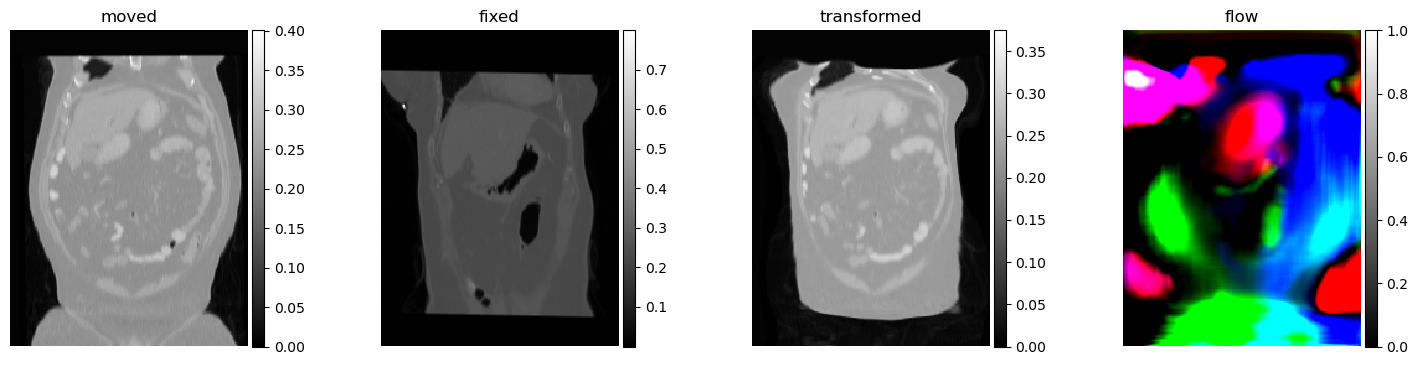

In [18]:
# view result
images = [img[0, depth] for img in test_input + test_pred]
titles = ['moved', 'fixed', 'transformed', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

In [19]:
def find_subarray(arr,subarr):
  for idx, val in enumerate(arr):
    if np.array_equal(val, subarr):
      return idx

In [20]:
def apply_displacement_field(input_image, displacement_field):
  h, w, d = input_image.shape

  # Apply displacement field to original resized picture using spatial transformer
  inputs_image = tf.keras.Input(shape=(h, w, d, 1))
  inputs_disp = tf.keras.Input(shape=(h, w, d, 3))

  spatial_transformer = vxm.layers.SpatialTransformer(name='transformer')
  moved_image = spatial_transformer([inputs_image, inputs_disp])

  # Define model
  transformer_model = tf.keras.Model(inputs=[inputs_image, inputs_disp], outputs=moved_image)

  # Make prediction
  prediction = transformer_model.predict([np.expand_dims(input_image, axis=0), np.expand_dims(displacement_field, axis=0)])[0]

  return np.squeeze(prediction, axis=-1)

In [21]:
"""
    1: "spleen",
    2: "right kidney",
    3: "left kidney",
    4: "gall bladder",
    5: "esophagus",
    6: "liver",
    7: "stomach",
    8: "aorta",
    9: "inferior vena cava",
    10: "portal and splenic vein",
    11: "pancreas",
    12: "left adrenal gland",
    13: "right adrenal gland"
"""
organ = 6

idx1 = find_subarray(training_images,np.squeeze(test_input[0][0],-1))

# apply displacement field on labels of one organ of moved image
displacement_field = test_pred[1][0]
all_labels = training_labels[idx1]
single_label = np.zeros_like(all_labels)
single_label[all_labels == organ] = all_labels[all_labels == organ]

predicted_label = apply_displacement_field(single_label,displacement_field)
predicted_label[predicted_label > 0] = 1 

1/1 [==============================] - 2s 2s/step


In [22]:
# get true labels for fixed image
fixed = test_input[1][0]
idx2 = find_subarray(training_images,np.squeeze(fixed,-1))
true_labels = training_labels[idx2]
true_label = np.zeros_like(true_labels)
true_label[true_labels == organ] = 1

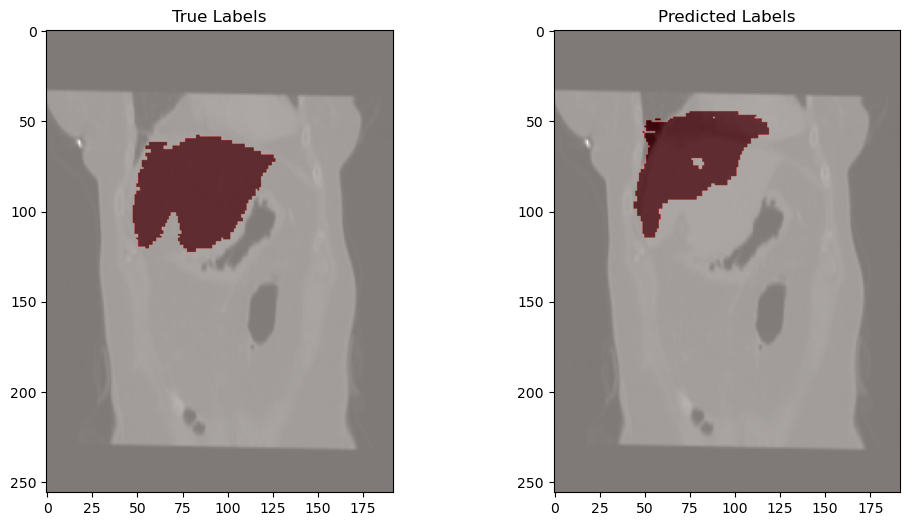

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(fixed[depth],cmap='gray')
axs[0].imshow(true_label[depth], cmap='Reds', alpha=0.5)
axs[0].set_title("True Labels")

axs[1].imshow(fixed[depth],cmap='gray')
axs[1].imshow(predicted_label[depth], cmap='Reds', alpha=0.5)
axs[1].set_title("Predicted Labels")

plt.show()

# Evaluation

In [24]:
def dice_score_tf(y_true, y_pred, smooth=1e-6):
    binary_y_true = tf.cast(y_true > 0, tf.float32)
    binary_y_pred = tf.cast(y_pred > 0, tf.float32)

    y_true_flat = tf.reshape(binary_y_true, [-1])
    y_pred_flat = tf.reshape(binary_y_pred, [-1])

    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    union = tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat)

    dice = (2. * intersection + smooth) / (union + smooth)
    return float(dice)

In [25]:
print("Dice: " + str(dice_score_tf(test_input[1][0], test_pred[0][0])))
print("MSE: " + str(np.mean(np.square(test_input[1][0] - test_pred[0][0]))))

Dice: 0.9155442118644714
MSE: 0.005287792100992271
